# Homework 6 (more of a tutorial, really)

As I was browsing through Kaggle the other day, I came upon a brand new dataset from the University of Puerto Rico, which contains images of bees entering their hive.  The task is to determine automatically which bees are carrying pollen.  Your job will be to develop a convolutional neural network that performs this task.  

## 1. Load Data (0 pts)

First, we need to load the bee data, which is included along with this homework.  Fortunately, the authors of the Kaggle dataset provided a nice set of files which will do this for us, which I have reproduced below

In [1]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

In [3]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)

    labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)

In [4]:
# Load the dataset (may take a few seconds)
X,y=dataset(imlist)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [5]:
# X has the following structure: X[imageid, y,x,channel]
print('X: ',X.shape)  # data
print('y: ',y.shape)  # target

print('Class 0: ',sum(y==0))
print('Class 1: ',sum(y==1))
print('Total  : ',len(y))

X:  (714, 300, 180, 3)
y:  (714,)
Class 0:  345
Class 1:  369
Total  :  714


We can plot a couple of the images below.  If you check out a couple of these, you will see that the visible difference when bees carry pollen is the presence of large fluffy balls of pollen on their back legs.

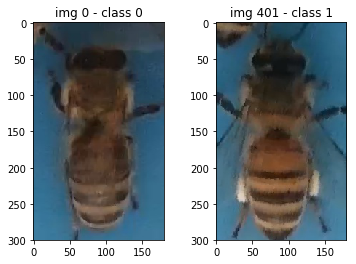

In [6]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]))

k=401
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]));

## 2. A convolutional network architecture for bee classification (40 pts)

**Implement a 2D convolutional neural network using Keras.  You are free to choose whatever network architecture you like.**

You can find all the relevant syntax for implementing such a network [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), the Keras convnet example for MNIST.

*(For the sake of comparison, I will share the one that I used:*

Layer 1: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 2: 4x4 Max-pooling layer

Layer 3: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 4: 4x4 Max-pooling layer

Layer 5: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 6: 4x4 Max-pooling layer

Layer 7: Flattening layer

Layer 8: Dropout layer with 0.2 dropout probability

Layer 9: 1 node sigmoid layer


In [22]:
import keras
import keras.models as km
import keras.layers as kl

import numpy as np

input_shape = ((300,180,3))

model = km.Sequential()
#! Add layers to your convolutional neural network   

model.add(kl.Conv2D(24, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))

model.add(kl.MaxPooling2D(pool_size=(4, 4)))

model.add(kl.Conv2D(24, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(kl.MaxPooling2D(pool_size=(4, 4)))

model.add(kl.Conv2D(24, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(kl.MaxPooling2D(pool_size=(4, 4)))

model.add(kl.Flatten())

model.add(kl.Dropout(0.2))

model.add(kl.Dense(1, activation='sigmoid')) 



## 3. Fitting the CNN to data (20 pts)

Compile your model, using a binary crossentropy loss function and an optimizer of your choosing (RMSprop worked well for me).  Select a batch size and number of epochs, and fit your model to the training data, while also keeping track of the test set accuracy.

**Plot the training and test accuracy of your model at each epoch.  Comment on whether you think the model is being overfit.**

In [25]:
model.compile(loss=keras.losses.mean_squared_logarithmic_error,                #! Specify a loss function
              optimizer=keras.optimizers.RMSprop(),           #! Specify an optimizer
              metrics=['accuracy'])

batch_size = 100                       #! Specify a batch size <-- # of examples per epock, higher batch size = more memory
epochs= 16                            #! Specify an epoch  
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,y_test))


Train on 571 samples, validate on 143 samples
Epoch 1/16
571/571 [==============================] - 25s 44ms/step - loss: 0.0646 - acc: 0.7933 - val_loss: 0.0387 - val_acc: 0.9021
Epoch 2/16
571/571 [==============================] - 25s 44ms/step - loss: 0.0402 - acc: 0.8984 - val_loss: 0.0571 - val_acc: 0.7832
Epoch 3/16
571/571 [==============================] - 25s 44ms/step - loss: 0.0448 - acc: 0.8687 - val_loss: 0.0357 - val_acc: 0.8741
Epoch 4/16
571/571 [==============================] - 25s 44ms/step - loss: 0.0347 - acc: 0.9019 - val_loss: 0.0361 - val_acc: 0.8811
Epoch 5/16
571/571 [==============================] - 25s 43ms/step - loss: 0.0436 - acc: 0.8757 - val_loss: 0.0361 - val_acc: 0.9231
Epoch 6/16
571/571 [==============================] - 24s 42ms/step - loss: 0.0378 - acc: 0.8949 - val_loss: 0.0358 - val_acc: 0.9441
Epoch 7/16
571/571 [==============================] - 24s 42ms/step - loss: 0.0305 - acc: 0.9229 - val_loss: 0.0352 - val_acc: 0.9301
Epoch 8/16
571/5

No handles with labels found to put in legend.


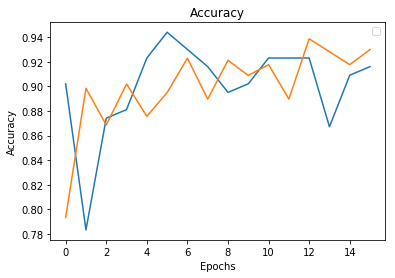

In [26]:
#! Plot test and training accuracy (note that the history.history object is a dictionary containing relevant info)
print(history)

plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])



## 4. Model evaluation (20 pts)

Now that you have a trained model, make a prediction for the test set (model.predict is a useful function for this).  **Compute and display a confusion matrix.  Select and display an example from the test set of a true positive, a true negative, a false positive, and a false negative.  Speculate on the reasons behind misclassification for images that your model predicted incorrectly**.

In [58]:
#! See above
prediction = model.predict(X_test)
discreet_predictions = [] 

# since we ran this through a sigmoid as our last layer the model feeds us a number between 1 and 0
# but we want to actually take this and make it either 1 or 0 so that's what this bit does
for item in prediction:
    if(item > .5):
        discreet_predictions.append(1)
    else:
        discreet_predictions.append(0)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(discreet_predictions,y_test)
print(cm)

[[66  6]
 [ 6 65]]


0
0
0
0


Text(0.5,1,'False Negative')

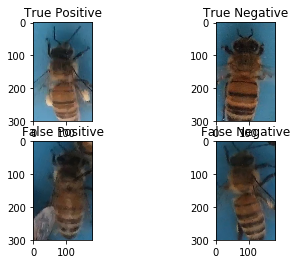

In [65]:
def getTruePositive(test_images, predictions, actual_values, which_true_positive):
    i = 0
    
    for j in range(0, len(predictions)):
        if(predictions[j] == actual_values[j] and predictions[j] == 1):
            if(i == which_true_positive):
                print(i)
                return test_images[j]
            else:
                i += 1

def getFalsePositive(test_images, predictions, actual_values, which_true_positive):
    i = 0
    for j in range(0, len(predictions)):
        if(predictions[j] != actual_values[j] and predictions[j] == 1):
                if(i == which_true_positive):
                    print(i)
                    return test_images[j]
                else:
                    i += 1

def getTrueNegative(test_images, predictions, actual_values, which_true_positive):
    i = 0
    for j in range(0, len(predictions)):
        if(predictions[j] == actual_values[j] and predictions[j] == 0):
                if(i == which_true_positive):
                    print(i)
                    return test_images[j]
                else:
                    i += 1

def getFalseNegative(test_images, predictions, actual_values, which_true_positive):
    i = 0
    for j in range(0, len(predictions)):
        if(predictions[j] != actual_values[j] and predictions[j] == 0):
                if(i == which_true_positive):
                    print(i)
                    return test_images[j]
                else:
                    i += 1

# There probably is a much easier built in method I could have used to get the false positive/negatives
# and true positive/negatives, but I created my own methods. The number you pass in at the end
# lets you pick which of the instances you want to see, just defaulting to the first ones seen in the 
# dataset but it's kind of fun to see all the false positives/negatives that the neural net missed
truePositiveImage = getTruePositive(X_test, discreet_predictions, y_test, 0)
trueNegativeImage = getTrueNegative(X_test, discreet_predictions, y_test, 0)
falsePositiveImage = getFalsePositive(X_test, discreet_predictions, y_test, 0)
falseNegativeImage = getFalseNegative(X_test, discreet_predictions, y_test, 0)

# ******
# Lets plot some tings...
# ******
fig,axes = plt.subplots(nrows=2,ncols=2)

plt.sca(axes[0,0])
plt.imshow(truePositiveImage)
plt.title('True Positive')

plt.sca(axes[0,1])
plt.imshow(trueNegativeImage)
plt.title('True Negative')

plt.sca(axes[1,0])
plt.imshow(falsePositiveImage)
plt.title('False Positive')

plt.sca(axes[1,1])
plt.imshow(falseNegativeImage)
plt.title('False Negative')

# Speculation #
After toggleing though the false positive and false negative images, I can see that sometimes the model mistakes the wings of the bee for balls of pollen. In the case of the false negatives I looked at, it seemed like the image was really dark or partially cut off or the bee had noticeably big bright legs/upper body that it mistook for pollen.